In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#사용할 모델 불러오기 위해
!pip install -U segmentation-models
%env SM_FRAMEWORK=tf.keras

     |████████████████████████████████| 51kB 8.9MB/s 
env: SM_FRAMEWORK=tf.keras


In [ ]:
#필요항목 import
import json
from tqdm import tqdm
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from shutil import copyfile
from glob import glob

import tensorflow as tf
from PIL import Image
from tensorflow import keras
keras.backend.set_image_data_format('channels_last')
import segmentation_models as sm

# 그래프, 이미지 보기
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Segmentation Models: using `tf.keras` framework.


In [ ]:
#데이터 split


def split_dataset(input_json, input_csv, output_dir, val_ratio, random_seed):
    random.seed(random_seed)

    with open(input_json) as json_reader:
        dataset = json.load(json_reader)

    images = dataset['images']
    annotations = dataset['annotations']
    categories = dataset['categories']

    # file_name에 prefix 디렉토리까지 포함 (CocoDataset 클래스를 사용하는 경우)
    # for image in images:
    #     image['file_name'] = '{}/{}'.format(image['file_name'][0], image['file_name'])

    image_ids = [x.get('id') for x in images]
    image_ids.sort()
    random.shuffle(image_ids)

    num_val = int(len(image_ids) * val_ratio)
    num_test = int(len(image_ids) * val_ratio)
    num_train = len(image_ids) - num_val - num_test
    

    image_ids_test, image_ids_val, image_ids_train = set(image_ids[:num_test]), set(image_ids[num_test:(num_test+num_val)]), set(image_ids[(num_test+num_val):])

    train_images = [x for x in images if x.get('id') in image_ids_train]
    val_images = [x for x in images if x.get('id') in image_ids_val]
    test_images = [x for x in images if x.get('id') in image_ids_test]
    train_annotations = [x for x in annotations if x.get('image_id') in image_ids_train]
    val_annotations = [x for x in annotations if x.get('image_id') in image_ids_val]
    test_annotations = [x for x in annotations if x.get('image_id') in image_ids_test]

    train_data = {
        'images': train_images,
        'annotations': train_annotations,
        'categories': categories,
    }

    val_data = {
        'images': val_images,
        'annotations': val_annotations,
        'categories': categories,
    }

    test_data = {
        'images': test_images,
        'annotations': test_annotations,
        'categories': categories,
    }

    output_seed_dir = os.path.join('MyDrive/project/', f'seed{random_seed}')
    os.makedirs(output_seed_dir, exist_ok=True)
    output_train_json = os.path.join(output_seed_dir, 'train.json')
    output_val_json = os.path.join(output_seed_dir, 'val.json')
    output_test_json = os.path.join(output_seed_dir, 'test.json')
    output_train_csv = os.path.join(output_seed_dir, 'train.csv')
    output_val_csv = os.path.join(output_seed_dir, 'val.csv')

    print(f'write {output_train_json}')
    with open(output_train_json, 'w') as train_writer:
        json.dump(train_data, train_writer)

    print(f'write {output_val_json}')
    with open(output_val_json, 'w') as val_writer:
        json.dump(val_data, val_writer)

    print(f'write {output_test_json}')
    with open(output_test_json, 'w') as test_writer:
        json.dump(test_data, test_writer)

    print(f'write {output_train_csv}, {output_val_csv}')
    with open(input_csv, 'r') as csv_reader, \
            open(output_train_csv, 'w') as train_writer, \
            open(output_val_csv, 'w') as val_writer:
        train_writer.write('ImageId,EncodedPixels,Height,Width,CategoryId\n')
        val_writer.write('ImageId,EncodedPixels,Height,Width,CategoryId\n')
        for line in csv_reader:
            if line.startswith('ImageId'): continue
            image_id, encoded_pixels, height, width, category_id = line.strip().split(',')
            image_id = int(image_id)
            if image_id in image_ids_train:
                train_writer.write(line)
            elif image_id in image_ids_val:
                val_writer.write(line)
            

In [ ]:
# 분리 실행, 한번만 할것
split_dataset(input_json='MyDrive/project/data/train.json',
              input_csv='MyDrive/project/data/train.csv',
              output_dir='MyDrive/project/dataset/',
              val_ratio=0.1,
              random_seed=13)

In [ ]:
# 이미지 파일 한 곳에 모으기 *한번만 실행
train_paths = glob(os.path.join('MyDrive', 'project', 'data', 'train', '*', '*.jpg'))
test_paths = glob(os.path.join('MyDrive', 'project', 'data', 'test', '*', '*.jpg'))
train_rename = ['MyDrive/project/data/train_all/' + train_path.split('/')[-1] for train_path in train_paths]
test_rename = ['MyDrive/project/data/test_all/' + test_path.split('/')[-1] for test_path in test_paths]

In [ ]:
#한번만
for i in tqdm(range(len(train_paths))):
    copyfile(train_paths[i], train_rename[i])

In [ ]:
#한번만
for i in tqdm(range(len(test_paths))):
    copyfile(test_paths[i], test_rename[i])

In [ ]:
# 분할 도중에 멈췄을 때
success_file = glob(os.path.join('MyDrive','project','data', 'train_all', '*.jpg'))

for i in tqdm(range(len(train_rename))):
        if train_rename[i] not in success_file:
            copyfile(train_paths[i], train_rename[i])

In [ ]:
# 두개 같으면 분할 완료
how_many = glob(os.path.join('MyDrive', 'project', 'data', 'train_all', '*.jpg'))
print(len(how_many))
print(len(train_paths))

95454
95454


In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [ ]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}.json'.format(folder,mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in tqdm(classes):
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # 중복자료 제거
    unique_images = []
    for i in (range(len(images))):
        if images[i] not in unique_images:
            unique_images.append(images[i])
    images = random.shuffle(unique_images)
    dataset_size = len(unique_images)

    return unique_images, dataset_size, coco
    

    '''#위에 실행 안 할때
    random.shuffle(images)
    dataset_size = len(images)

    return images, dataset_size, coco'''

In [ ]:
#full train (소요시간 큼)
'''classes = (
    'top', 'blouse', 't-shirt', 'Knitted fabri', 'shirt', 'bra top', 
    'hood', 'blue jeans', 'pants', 'skirt', 'leggings', 'jogger pants', 
    'coat', 'jacket', 'jumper', 'padding jacket', 'best', 'kadigan', 
    'zip up', 'dress', 'jumpsuit')
n_classes = len(classes)'''

#sub train (몇가지 클래스만 train)
classes = (
    't-shirt', 'kadigan')
n_classes = len(classes)

In [ ]:

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None


def getImage(imageObj, img_folder, input_image_size):
    
    dataset_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    dataset_img = cv2.resize(dataset_img, input_image_size)
    return dataset_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    dataset_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        dataset_mask = np.maximum(new_mask, dataset_mask)

    dataset_mask = dataset_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return dataset_mask  

In [ ]:
def dataGeneratorcoco(images, classes, coco, folder, 
                      input_image_size=(800,800), batch_size=4, mode='train'):
    
    img_folder = '{}/{}_all'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): 
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

In [ ]:

#데이터 불러오기    

images, dataset_size, coco=filterDataset(folder='MyDrive/project/dataset/seed13', mode='train', classes=classes)
train_len = len(images)
train = dataGeneratorcoco(
images=images, coco=coco, classes=classes, folder='MyDrive/project/dataset/seed13', mode='train')


images, dataset_size, coco=filterDataset(folder='MyDrive/project/dataset/seed13', mode='val', classes=classes)
val_len = len(images)
val = dataGeneratorcoco(
images=images, coco=coco, classes=classes, folder='MyDrive/project/dataset/seed13', mode='train',batch_size=1)


NameError: name 'filterDataset' is not defined

In [ ]:
# 잘 준비되었나요?
visualizeGenerator(val)

In [ ]:
a = list(range(len(classes)))
a.insert(len(classes),0.5)
a

[0, 1, 0.5]

In [ ]:
#모델링


BACKBONE = 'resnet34'
LR = 0.0001
EPOCHS = 5
preprocess_input = sm.get_preprocessing(BACKBONE)
activation = 'softmax'
optim = keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

dice_loss = sm.losses.DiceLoss(class_weights=np.array(a)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

callbacks = [
    keras.callbacks.ModelCheckpoint('MyDrive/project/1best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]


model = sm.Unet(BACKBONE, classes=n_classes+1, activation=activation)
model.compile(optim, total_loss, metrics)






85524480/85521592 [==============================] - 1s 0us/step


In [ ]:
# fit_generator가 없어지며 fit으로 통일

history = model.fit(
    x=train, 
    steps_per_epoch=train_len//4, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val, 
    validation_steps=val_len
)

Epoch 1/5
266/266 [==============================] - 373s 1s/step - loss: 0.8106 - iou_score: 0.3211 - f1-score: 0.3254 - val_loss: 1.2491 - val_iou_score: 0.1580 - val_f1-score: 0.2052
Epoch 2/5
266/266 [==============================] - 190s 716ms/step - loss: 0.7582 - iou_score: 0.4627 - f1-score: 0.3933 - val_loss: 1.0811 - val_iou_score: 0.1216 - val_f1-score: 0.1759
Epoch 3/5
266/266 [==============================] - 189s 712ms/step - loss: 0.7508 - iou_score: 0.4672 - f1-score: 0.3959 - val_loss: 0.8622 - val_iou_score: 0.2881 - val_f1-score: 0.3209
Epoch 4/5
266/266 [==============================] - 189s 712ms/step - loss: 0.7440 - iou_score: 0.4958 - f1-score: 0.4051 - val_loss: 0.7419 - val_iou_score: 0.4549 - val_f1-score: 0.3863
Epoch 5/5
266/266 [==============================] - 190s 714ms/step - loss: 0.7408 - iou_score: 0.5144 - f1-score: 0.4110 - val_loss: 0.7329 - val_iou_score: 0.5234 - val_f1-score: 0.4111


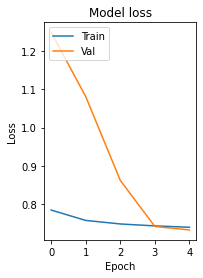

In [ ]:
#loss 확인

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# best weights 불러오기
model.load_weights('MyDrive/project/1best_model.h5')

In [ ]:
# test

images, dataset_size, coco = filterDataset(folder='MyDrive/project/dataset/seed13', mode='test', classes=classes)
test_len = len(images)
test = dataGeneratorcoco(
    images=images, coco=coco, classes=classes, folder='MyDrive/project/dataset/seed13', batch_size=1, mode='train')

100%|██████████| 2/2 [00:00<00:00, 1148.97it/s]

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [ ]:

scores = model.evaluate(test)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

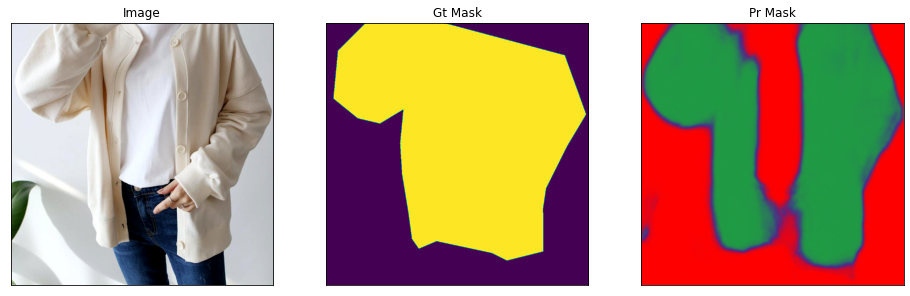

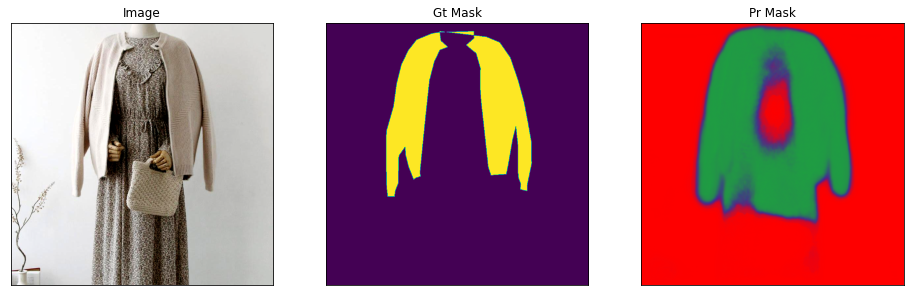

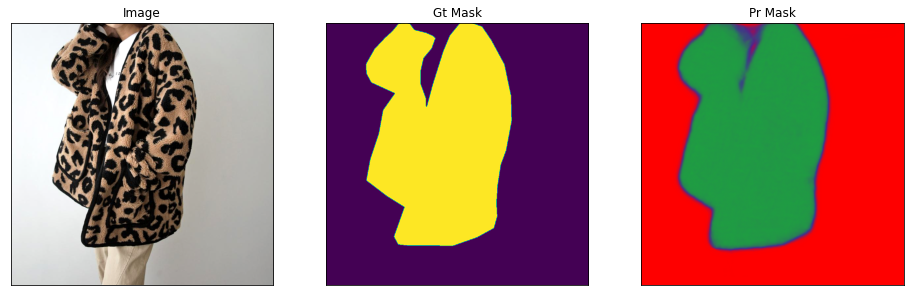

In [ ]:
n = 3
ids = np.random.choice(np.arange(test_len), size=n)
input_image_size = (800, 800)
mask = np.zeros((1, input_image_size[0], input_image_size[1], 1)).astype('float')
img_folder = os.path.join('MyDrive/project/dataset/seed13','train_all')

for i in ids:
    catIds = coco.getCatIds(catNms=classes)
    image, gt_mask= getImage(images[i], img_folder, input_image_size), getNormalMask(images[i], classes, coco, catIds, input_image_size)
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze()
    )